In [1]:
import numpy as np
from scipy.stats import rv_discrete
from matplotlib import pyplot as plt
import cvxpy as cp
import pickle
import gurobipy as gp
from gurobipy import GRB
# import gurobipy

In [2]:
import utils
def run_extremes(N, W, pmf_cust, pmf_serv, gurobi_flag = 1):
    Ex = round (np.sum(np.outer(pmf_cust,pmf_serv)*W), 3) 
    print("Expected cost for c = 0 case:", Ex )
    if gurobi_flag == 1:
        fluid_sol = utils.fluid_solution_gurobi(N, W, pmf_cust, pmf_serv)
    else:
        fluid_sol = utils.fluid_solution(N, W, pmf_cust, pmf_serv)
#     print("\nFluid Solution:\n")
#     print(fluid_sol)
    return([Ex,fluid_sol])
def plot_from_sim_paths(file_name, save_file= 0, frac = 0):
    with open(file_name,'rb') as f:
        M_res,B_res, N, W, pmf_cust, pmf_serv = pickle.load(f)
    Q_paths_M = M_res["Q_paths"]
    C_paths_M = M_res["C_paths"]
    Q_paths_B = B_res["Q_paths"]
    C_paths_B = B_res["C_paths"]
    (average_cost_M, average_queue_M) = utils.average_paths(C_paths_M,Q_paths_M, frac)
    (average_cost_B, average_queue_B) = utils.average_paths(C_paths_B,Q_paths_B, frac)
    [Ex,fluid_sol] = run_extremes(N,W,pmf_cust,pmf_serv)
    utils.qc_plot(Ex,fluid_sol,average_queue_B,average_cost_B,average_queue_M,average_cost_M, save_file)
    
def generate_weights(N_grid, is_spatial = 1):
    Weights = np.zeros(shape=(N_grid,N_grid))
    if is_spatial:
        X = np.arange(0.5,N_grid,1)
        Y = np.arange(0.5,N_grid,1)
        cell_locs = []
        for i in range(N_grid):
            for j in range(N_grid):
                cell_locs.append([X[i],Y[j]])
        N_cells = N_grid*N_grid
        Weights = np.zeros(shape=(N_cells,N_cells))

        for i in range(N_cells):
            for j in range(N_cells):
                Weights[i,j] = np.sqrt((cell_locs[i][0] - cell_locs[j][0])**2 + (cell_locs[i][1] - cell_locs[j][1])**2)
        print(Weights)
    else:
        rand_weights = np.random.rand(N_grid, N_grid)
        N_cells = N_grid*N_grid
        for counter in range(N_cells):
            for i in range(N_grid):
                for j in range(N_grid):
                    for k in range(N_grid):
                        rand_weights[i,j] = min(rand_weights[i,j],rand_weights[i,k] + rand_weights[k,j] )
        print(rand_weights)
        Weights = rand_weights
    return(Weights)

Expected cost for c = 0 case: 0.854
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-03
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 8 rows, 16 columns and 32 nonzeros
Model fingerprint: 0x1e0e9b1b
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 3e-01]
Presolve time: 0.05s
Presolved: 8 rows, 16 columns, 32 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.17 seconds (0.00 work units)
Optimal objective  0.000000000e+00
Objective Value: 0.00
x:  [[0.25 0.   0.   0.  ]
 [0.   0.25 0.   0.  ]
 [0.   0.   0.25 0.  ]
 [0.   0.   0.   0.25]]


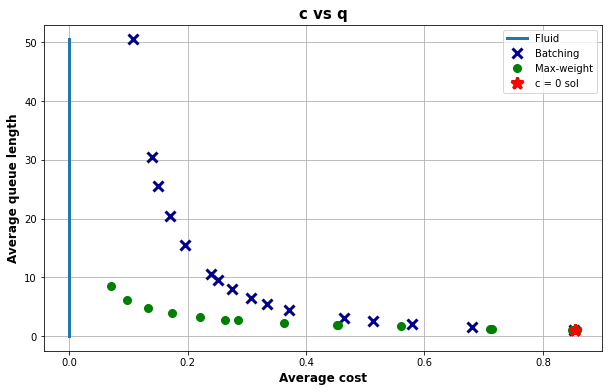

In [16]:
file_name = '../sim_paths_spatial_uniform_4.pkl'
plot_from_sim_paths(file_name)

In [3]:
alpha_values = alpha_values = np.asarray( [0, 0.2, 0.25, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.675, 0.7, 0.725, 0.75, 0.8, 0.825, 0.85, 0.875,  0.9, 0.925, 0.95] )

In [4]:
alpha_values.shape

(21,)

In [41]:
N = 2

is_spatial = 1
W = generate_weights(N,is_spatial)

time_steps = 10000


if is_spatial:
    N = N*N
    
pmf_cust = np.ones(N)*(1/N)
pmf_serv = np.ones(N)*(1/N)
print(pmf_cust,pmf_serv)

arrival_ids = np.arange(0,N,1)
cust_process = rv_discrete(name='cust_arr', values=(arrival_ids, pmf_cust))
serv_process = rv_discrete(name='serv_arr', values=(arrival_ids, pmf_serv))

[[0.         1.         1.         1.41421356]
 [1.         0.         1.41421356 1.        ]
 [1.         1.41421356 0.         1.        ]
 [1.41421356 1.         1.         0.        ]]
[0.25 0.25 0.25 0.25] [0.25 0.25 0.25 0.25]


In [4]:
cust_arrivals = cust_process.rvs( size = time_steps )
serv_arrivals = serv_process.rvs( size = time_steps )

In [5]:
alpha = 0.9
Q_mw = []
Qtilde_mw = []
Mstars_mw = []

In [6]:
q = np.zeros(N)
q[cust_arrivals[0]] = 1
qtilde = np.zeros(N)
qtilde[serv_arrivals[0]] = 1

cost_path_mw = [0]
total_queue = []
total_queue.append(np.sum(q))

for k in range(1,time_steps):
    # Maxweight Matching
    M = cp.Variable((N,N),integer=True)
    constraints = []
    for i in range(N):
        constraints.append( cp.sum(M[i,:]) <= q[i] )
        constraints.append( cp.sum(M[:,i]) <= qtilde[i] )
    constraints.append( M[:,:]>=0 )

    objective = cp.Maximize( cp.sum( (1-alpha)*( cp.multiply( q, cp.sum(M, axis=1) ) + cp.multiply( qtilde, cp.sum(M, axis=0) ) ) )
                            - cp.sum( alpha*cp.multiply( W,M  ) ) )
    problem  = cp.Problem(objective, constraints)         
    problem.solve(solver="GLPK_MI")
    # print("q=",q)
    # print("qtilde=",qtilde)
    # print(problem)


    # Check arrivals
    a = np.zeros(N)
    atilde = np.zeros(N)

    a[cust_arrivals[k]] = 1
    atilde[serv_arrivals[k]] = 1
    # State Update
    Mstar = M.value
    # print("M=", Mstar)
    matching_cost = np.sum(np.multiply(Mstar,W)) 
    q = q + a - np.sum(Mstar, 1)
    qtilde = qtilde + atilde - np.sum(Mstar,0)
    Q_mw.append(q)
    Qtilde_mw.append(qtilde)
    Mstars_mw.append(Mstar)
    total_queue.append(np.sum(q))
    cost_path_mw.append(matching_cost)

In [7]:
average_cost_mw = np.average(cost_path_mw)
print(average_cost_mw)
average_queue_mw = np.average(total_queue)
print(average_queue_mw)

0.11806467529817258
4.7633


In [8]:
T = 9
Q_b = []
Qtilde_b = []
Mstars_b = []

In [9]:
q = np.zeros(N)
q[cust_arrivals[0]] = 1
qtilde = np.zeros(N)
qtilde[serv_arrivals[0]] = 1

running_cost = 0
cost_path = [0]
total_queue = [] 
total_queue.append(np.sum(q))

for k in range(1,time_steps):
    # Check arrivals
    a = np.zeros(N)
    atilde = np.zeros(N)

    a[cust_arrivals[k]] = 1
    atilde[serv_arrivals[k]] = 1
    # State Update
    Mstar = np.zeros(shape=(N,N))

    # Matching is done every T time steps 
    if(k%T==0):
        constraints = []
        M = cp.Variable((N,N),integer=True)
        constraints = []
        for i in range(N):
            constraints.append( cp.sum(M[i,:]) == q[i] )
            constraints.append( cp.sum(M[:,i]) == qtilde[i] )
        constraints.append( M[:,:]>=0 )

        objective = cp.Minimize( cp.sum( cp.multiply( W, M ) ) )
        problem  = cp.Problem(objective, constraints)         
        problem.solve(solver="GLPK_MI")
        Mstar = M.value

    running_cost += np.sum(np.multiply(Mstar,W))
    q = q + a - np.sum(Mstar, 1)
    if q[0] < 0:
        print(q-a+np.sum(Mstar, 1))
        print(Mstar, k)
        print(constraints)
        break
    qtilde = qtilde + atilde - np.sum(Mstar,0)
    Q_b.append(q)
    Qtilde_b.append(qtilde)
    Mstars_b.append(Mstar)
    total_queue.append(np.sum(q))
    cost_path.append(np.sum(np.multiply(Mstar,W)))

In [10]:
average_cost_b = np.average(cost_path)
print(average_cost_b)
average_queue_b = np.average(total_queue)
print(average_queue_b)

0.34715129855222066
4.9996


In [16]:
with open("../single_path_run.pkl", 'wb') as f:
    pickle.dump([Q_mw, Qtilde_mw, Mstars_mw, Q_b, Qtilde_b, Mstars_b ],f)

In [3]:
with open("../single_path_run.pkl", 'rb') as f:
    Q_mw, Qtilde_mw, Mstars_mw, Q_b, Qtilde_b, Mstars_b = pickle.load(f)

In [10]:
Q_mw = np.asarray(Q_mw,dtype='int64')

In [11]:
Q_mw = np.asarray(Q_mw)
Qtilde_mw = np.asarray(Qtilde_mw)
Mstars_mw = np.asarray(Mstars_mw)

In [12]:
Q_b = np.asarray(Q_b)
Qtilde_b = np.asarray(Qtilde_b)
Mstars_b = np.asarray(Mstars_b)

Expected cost for c = 0 case: 0.854
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 8 rows, 16 columns and 32 nonzeros
Model fingerprint: 0x1e0e9b1b
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 3e-01]
Presolve time: 0.01s
Presolved: 8 rows, 16 columns, 32 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds (0.00 work units)
Optimal objective  0.000000000e+00
Objective Value: 0.00
x:  [[0.25 0.   0.   0.  ]
 [0.   0.25 0.   0.  ]
 [0.   0.   0.25 0.  ]
 [0.   0.   0.   0.25]]


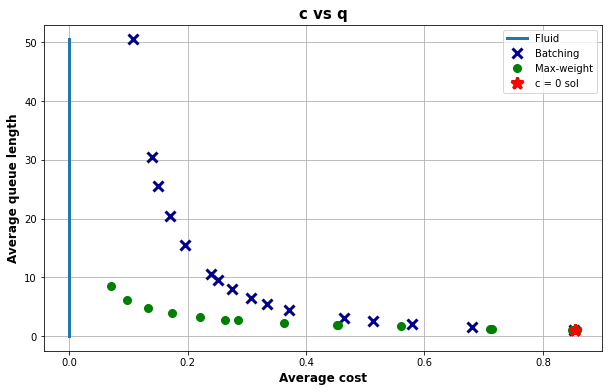

In [17]:
file_name = '../sim_paths_spatial_uniform_4.pkl'
plot_from_sim_paths(file_name)

### Analysis

In [8]:
Mstars_b = np.asarray(Mstars_b)

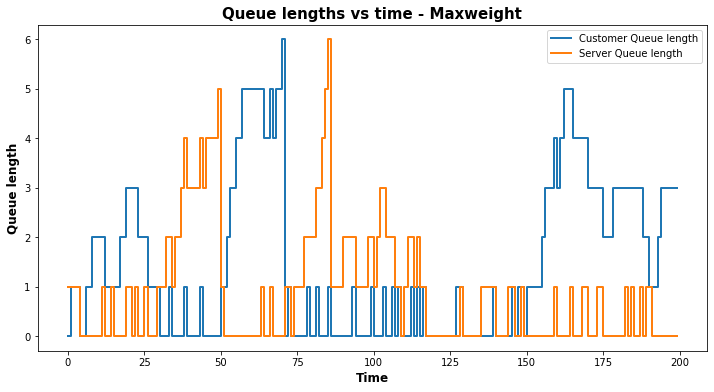

In [30]:
plt.figure( figsize=(12,6) )
plot_length = 200
plt.step(np.arange(0,plot_length,1), Q_mw[:plot_length,0],linewidth=2)
plt.step(np.arange(0,plot_length,1), Qtilde_mw[:plot_length,0],linewidth=2)
plt.ylabel("Queue length", weight='bold',fontsize=12)
plt.xlabel("Time", weight='bold',fontsize=12)
plt.title("Queue lengths vs time - Maxweight", weight='bold',fontsize=15)
plt.legend(['Customer Queue length', 'Server Queue length'])
plt.savefig('../../plots_stash/single-path-mw.jpg')

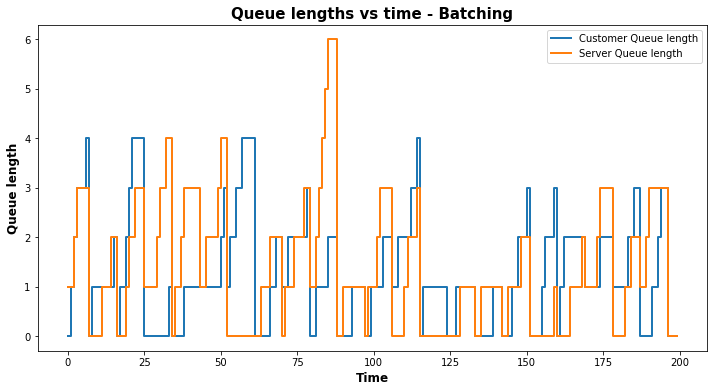

In [34]:
plt.figure( figsize=(12,6) )
plot_length = 200
plt.step(np.arange(0,plot_length,1), Q_b[:plot_length,0],linewidth=2)
plt.step(np.arange(0,plot_length,1), Qtilde_b[:plot_length,0],linewidth=2)
plt.ylabel("Queue length", weight='bold',fontsize=12)
plt.xlabel("Time", weight='bold',fontsize=12)
plt.title("Queue lengths vs time - Batching", weight='bold',fontsize=15)
plt.legend(['Customer Queue length', 'Server Queue length'])
plt.savefig('../../plots_stash/single-path-B.jpg')

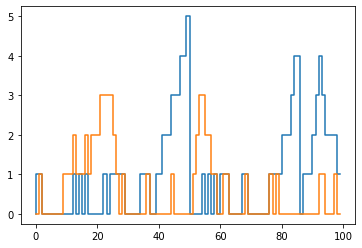

In [29]:

plot_length = 100
plt.step(np.arange(0,plot_length,1), Q_mw[:plot_length,1])
plt.step(np.arange(0,plot_length,1), Qtilde_mw[:plot_length,1])

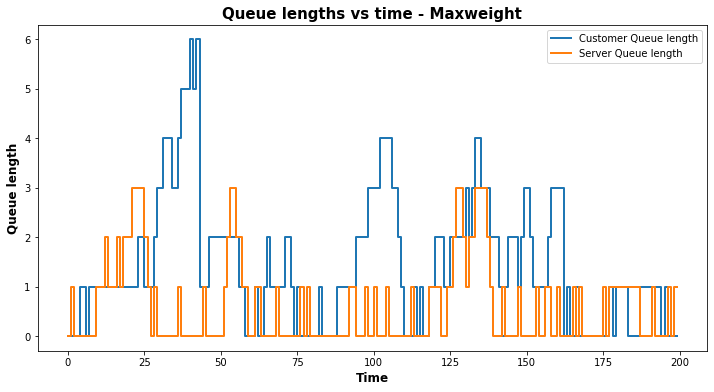

In [37]:
plt.figure( figsize=(12,6) )
plot_length = 200
plt.step(np.arange(0,plot_length,1), Q_mw[:plot_length,2],linewidth=2)
plt.step(np.arange(0,plot_length,1), Qtilde_mw[:plot_length,1],linewidth=2)
plt.ylabel("Queue length", weight='bold',fontsize=12)
plt.xlabel("Time", weight='bold',fontsize=12)
plt.title("Queue lengths vs time - Maxweight", weight='bold',fontsize=15)
plt.legend(['Customer Queue length', 'Server Queue length'])
plt.savefig('../../plots_stash/single-path-mw-1.jpg')

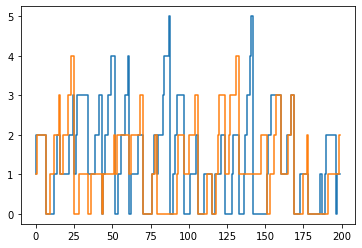

In [32]:
Tplot_length = 100
plt.step(np.arange(0,plot_length,1), Q_b[:plot_length,1])
plt.step(np.arange(0,plot_length,1), Qtilde_b[:plot_length,1])

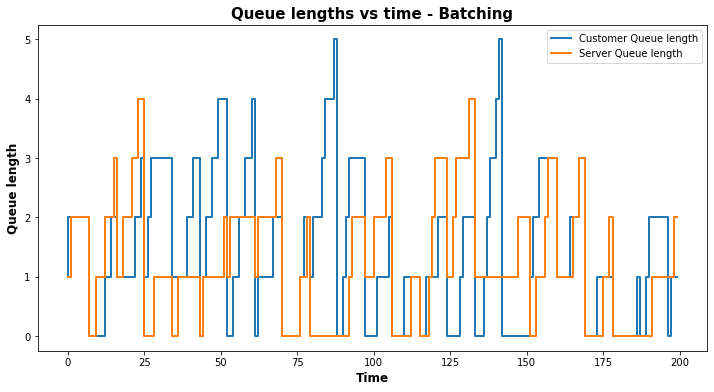

In [36]:
plt.figure( figsize=(12,6) )
plot_length = 200
plt.step(np.arange(0,plot_length,1), Q_b[:plot_length,1],linewidth=2)
plt.step(np.arange(0,plot_length,1), Qtilde_b[:plot_length,1],linewidth=2)
plt.ylabel("Queue length", weight='bold',fontsize=12)
plt.xlabel("Time", weight='bold',fontsize=12)
plt.title("Queue lengths vs time - Batching", weight='bold',fontsize=15)
plt.legend(['Customer Queue length', 'Server Queue length'])
plt.savefig('../../plots_stash/single-path-B-1.jpg')

In [48]:
N = int( len(Mstars_mw) )
cost_path_mw = np.zeros(N)
cost_path_b  = np.zeros(N)
for i in range(N):
    cost_path_mw[i] = np.sum( np.multiply(Mstars_mw[i],W) )
    cost_path_b[i] = np.sum( np.multiply(Mstars_b[i],W) )

In [49]:
np.multiply(Mstars_mw[i],W)

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

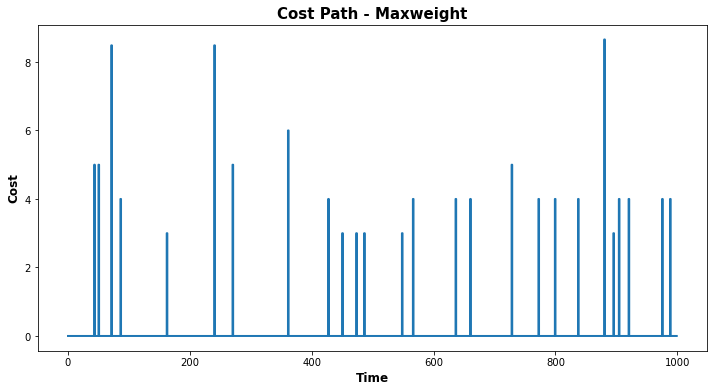

In [62]:
plt.figure( figsize=(12,6) )
plot_length = 1000
plt.step(np.arange(0,plot_length,1), cost_path_mw[:plot_length],linewidth=2)
plt.ylabel("Cost", weight='bold',fontsize=12)
plt.xlabel("Time", weight='bold',fontsize=12)
plt.title("Cost Path - Maxweight", weight='bold',fontsize=15)
plt.savefig('../../plots_stash/cost-path-MW.jpg')

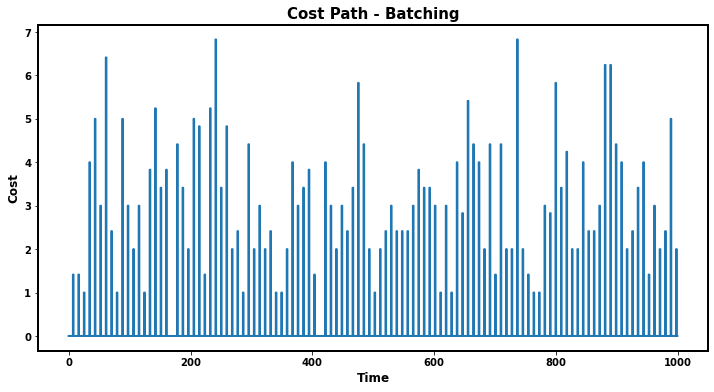

In [66]:
plt.figure( figsize=(12,6) )
plot_length = 1000
plt.step(np.arange(0,plot_length,1), cost_path_b[:plot_length],linewidth=2)
plt.ylabel("Cost", weight='bold',fontsize=12)
plt.xlabel("Time", weight='bold',fontsize=12)
plt.title("Cost Path - Batching", weight='bold',fontsize=15)
plt.savefig('../../plots_stash/cost-path-B.jpg')

In [73]:
cost_path_b = []
for i in range(9999):
    cost_path_b.append(np.sum(np.multiply(Mstars_b[i],W)))

In [74]:
cost_path_b = np.asarray(cost_path_b)

In [62]:
W

array([[0.        , 1.        , 1.        , 1.41421356],
       [1.        , 0.        , 1.41421356, 1.        ],
       [1.        , 1.41421356, 0.        , 1.        ],
       [1.41421356, 1.        , 1.        , 0.        ]])

In [68]:
Mstars_mw[22]

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 4., 0., 0.]])

In [79]:
np.sum(Mstars_mw,0)

array([[2146.,  141.,  167.,   58.],
       [ 152., 2210.,   33.,  161.],
       [ 112.,   35., 2202.,  181.],
       [  44.,   79.,  105., 2171.]])

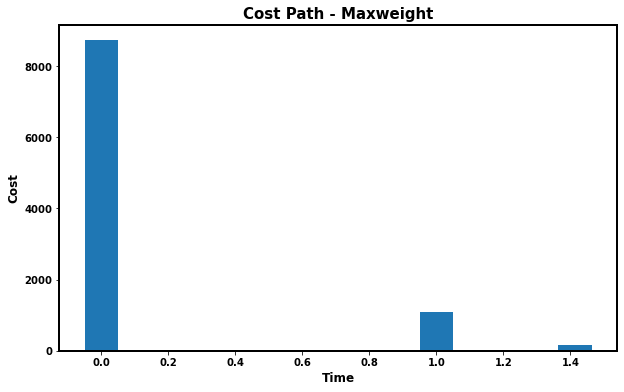

In [79]:
plt.figure( figsize=(10,6) )
new = [2146+2210+2202+2171, 9997-(2146+2210+2202+2171)-(44+35+33+58), 44+35+33+58]
plt.bar([0,1,1.414],new,0.1)
# plt.grid(True)
# rc('axes', linewidth=2)
# rc('font', weight='bold')
plt.ylabel("Cost", weight='bold',fontsize=12)
plt.xlabel("Time", weight='bold',fontsize=12)
plt.title("Cost Path - Maxweight", weight='bold',fontsize=15)
plt.savefig('../../plots_stash/cost-distribution-MW.jpg')

In [80]:
np.sum(Mstars_b,0)

array([[1756.,  368.,  254.,  203.],
       [ 286., 1726.,  186.,  251.],
       [ 239.,  226., 1718.,  349.],
       [ 195.,  256.,  323., 1663.]])

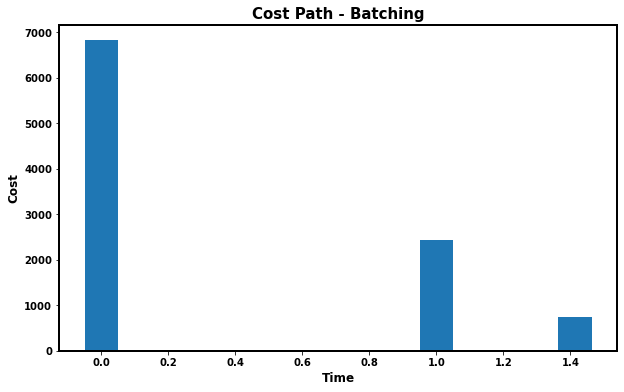

In [81]:
plt.figure( figsize=(10,6) )
batching = [1702+1709+1703+1706, 9999-(1702+1709+1703+1706)-(158+194+210+190), 158+194+210+190]
plt.bar([0,1,1.414],batching,0.1)
plt.ylabel("Cost", weight='bold',fontsize=12)
plt.xlabel("Time", weight='bold',fontsize=12)
plt.title("Cost Path - Batching", weight='bold',fontsize=15)
plt.savefig('../../plots_stash/cost-distribution-B.jpg')

In [96]:
new

[8729, 1098, 170]

In [97]:
batching

[6820, 2427, 752]

In [ ]:
    Q_mw.append(q)
    Qtilde_mw.append(qtilde)
    Mstars_mw.append(Mstar)
    total_queue.append(np.sum(q))
    cost_path_mw.append(matching_cost)

In [15]:
Q_mw = np.asarray(Q_mw)
Q_mw.shape

(9999, 4)

(array([4098., 2566., 1296.,    0.,  923.,  569.,    0.,  376.,  144.,
          27.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

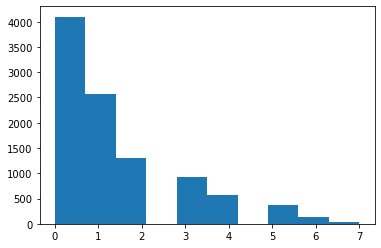

In [18]:
plt.hist(Q_mw[:,0])

In [43]:
import collections
counter = collections.Counter(Q_mw[:,0])
print(counter)
plt.bar(counter._keys,counter.v_alues)

Counter({0.0: 4098, 1.0: 2566, 2.0: 1296, 3.0: 923, 4.0: 569, 5.0: 376, 6.0: 144, 7.0: 27})


AttributeError: 'Counter' object has no attribute '_keys'

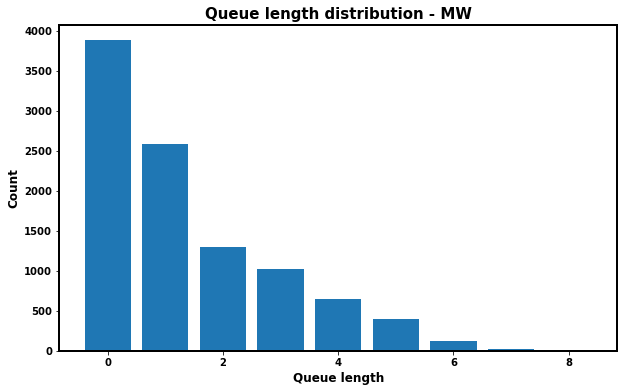

In [77]:
plt.figure( figsize=(10,6) )

Q_mw = Q_mw.astype('int64')
plt.bar(np.unique(Q_mw[:,0]), np.bincount(Q_mw[:,0]) )

plt.ylabel("Count", weight='bold',fontsize=12)
plt.xlabel("Queue length", weight='bold',fontsize=12)
plt.title("Queue length distribution - MW", weight='bold',fontsize=15)
plt.savefig('../../plots_stash/queue-distribution-MW.jpg')

Text(0.5, 1.0, 'Queue length distribution - B')

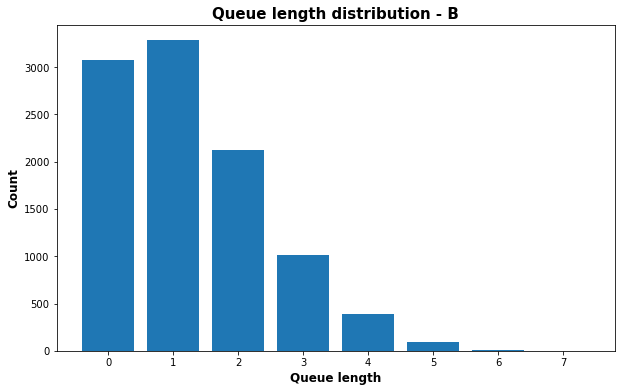

In [14]:
plt.figure(figsize=(10,6))
Q_b = np.asarray(Q_b)
Q_b = Q_b.astype('int64')
i = 0
plt.bar(np.unique(Q_b[:,i]), np.bincount(Q_b[:,i]) )
plt.ylabel("Count", weight='bold',fontsize=12)
plt.xlabel("Queue length", weight='bold',fontsize=12)
plt.title("Queue length distribution - B", weight='bold',fontsize=15)
# plt.savefig('../../plots_stash/queue-distribution-B.jpg')

(array([3.111e+03, 3.228e+03, 2.189e+03, 0.000e+00, 9.970e+02, 3.410e+02,
        0.000e+00, 1.110e+02, 2.000e+01, 2.000e+00]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

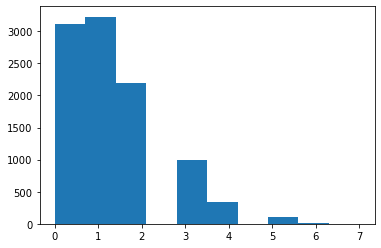

In [35]:
Q_b = np.asarray(Q_b)
plt.hist(Q_b[:,2])

In [34]:
np.unique(Q_b)

array([0., 1., 2., 3., 4., 5., 6., 7.])

In [30]:
np.random.random(1)

array([0.81236423])

### Distribution for Q_mw

#### MLE geometric

In [57]:
p = 9999/np.sum(Q_mw[:,1])
print(p)

0.8746501049685095


In [58]:
vals = np.unique(Q_mw[:,1])
bincounts= np.bincount(Q_mw[:,1])
probabs = bincounts/9999

In [59]:
geom_fit = [p, p*(1-p), p*((1-p)**2), p*((1-p)**3) ]

In [60]:
print(probabs)

[4.51545155e-01 2.56125613e-01 1.20912091e-01 8.84088409e-02
 4.87048705e-02 2.23022302e-02 1.04010401e-02 1.40014001e-03
 2.00020002e-04]


In [61]:
print(geom_fit)

[0.8746501049685095, 0.10963729884708483, 0.01374302390201824, 0.0017226866035332518]


can't be negative binomial because -ve binomial is not uniformly decreasing

<BarContainer object of 9 artists>

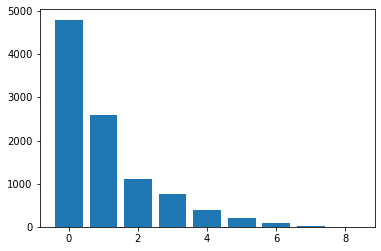

In [7]:
#Q_mw = np.asarray(Q_mw)
#Q_mw = Q_mw.astype('int64')
plt.bar(np.unique(Q_mw[:,3]), np.bincount(Q_mw[:,3]) )

In [8]:
Q_mw.shape

(9999, 4)

<BarContainer object of 9 artists>

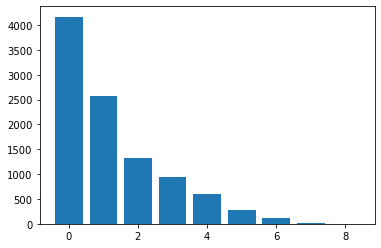

In [63]:
Q_mw = Q_mw.astype('int64')
plt.bar(np.unique(Q_mw[:,2]), np.bincount(Q_mw[:,2]) )

<BarContainer object of 9 artists>

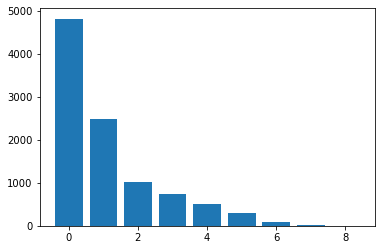

In [64]:
Q_mw = Q_mw.astype('int64')
plt.bar(np.unique(Q_mw[:,3]), np.bincount(Q_mw[:,3]) )

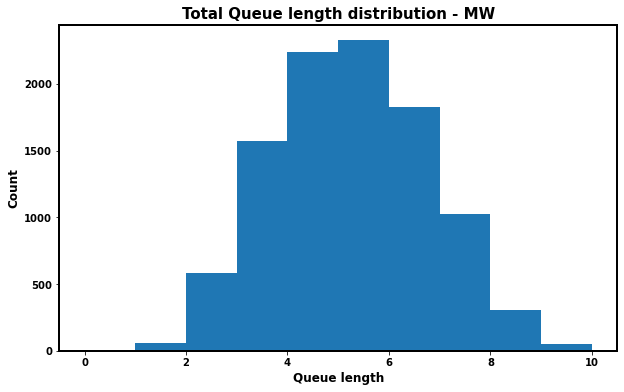

In [84]:
plt.figure(figsize=(10,6))
plt.hist(np.sum(Q_mw,axis=1), bins = np.arange(0,11,1))
plt.ylabel("Count", weight='bold',fontsize=12)
plt.xlabel("Queue length", weight='bold',fontsize=12)
plt.title("Total Queue length distribution - MW", weight='bold',fontsize=15)
plt.savefig('../../plots_stash/total-queue-distribution-MW.jpg')

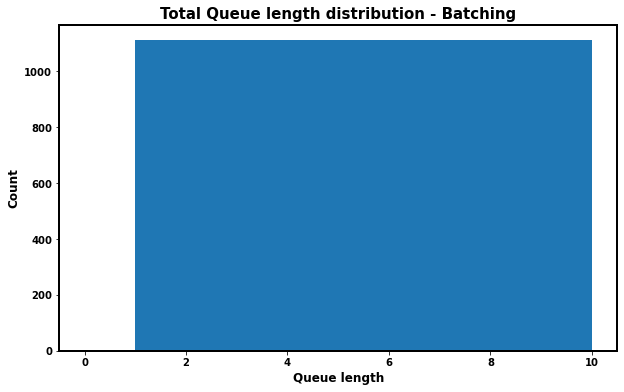

In [85]:
plt.figure(figsize=(10,6))
plt.hist(np.sum(Q_b,axis=1), bins = np.arange(0,11,1))
plt.ylabel("Count", weight='bold',fontsize=12)
plt.xlabel("Queue length", weight='bold',fontsize=12)
plt.title("Total Queue length distribution - Batching", weight='bold',fontsize=15)
plt.savefig('../../plots_stash/total-queue-distribution-B.jpg')

In [72]:
bins = np.arange(0,10,1)
print(bins)

[0 1 2 3 4 5 6 7 8 9]


In [8]:
file_name = '../sim_paths_spatial_uniform_4.pkl'
with open(file_name,'rb') as f:
    M_res,B_res, N, W, pmf_cust, pmf_serv = pickle.load(f)
Q_paths_M = M_res["Q_paths"]
C_paths_M = M_res["C_paths"]
Q_paths_B = B_res["Q_paths"]
C_paths_B = B_res["C_paths"]

In [9]:
Q_paths_M = np.asarray(Q_paths_M,dtype='int64')
Q_paths_B = np.asarray(Q_paths_B,dtype='int64')

(array([    0., 24295., 67282.,  8423.,     0.,     0.,     0.,     0.,
            0.,     0.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <BarContainer object of 10 artists>)

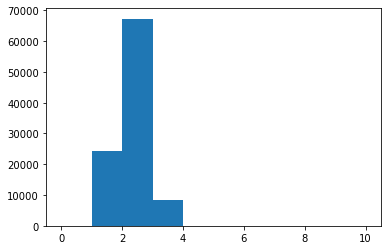

In [10]:
plt.hist(Q_paths_M[15,:], bins = np.arange(0,11,1))

In [82]:
Q_paths_M.shape

(25, 100000)

In [12]:
np.savetxt( "../full_queue.txt", np.sum(Q_mw,axis=1) )

In [7]:
Q_mw[:,0].shape

(9999,)

<BarContainer object of 8 artists>

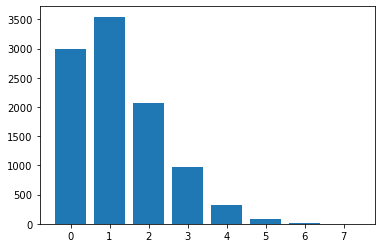

In [18]:
Q_b = np.asarray(Q_b, dtype='int64')
plt.bar(np.unique(Q_b[:,3]), np.bincount(Q_b[:,3]) )